# Kernel Design

It's easy to make new kernels in GPflow. To demonstrate, we'll have a look at the Brownian motion kernel, whose function is 
$$
k(x, x') = \sigma^2 \text{min}(x, x')
$$
where $\sigma^2$ is a variance parameter. 

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, positive
plt.style.use('ggplot')
%matplotlib inline

To make this new kernel class, we inherit from the base class `gpflow.kernels.Kernel` and implement the three functions below. **NOTE:** Depending on the kernel to be implemented, other classes can be more adequate. For example, if the kernel to be implemented is stationary, you can immediately subclass `gpflow.kernels.Stationary` (at which point you 
only have to override `K_r` or `K_r2`; see the `Stationary` class docstring).

#### `__init__`
In this simple example, the constructor takes no argument (though it could, if that was convenient, for example to pass in an initial value for `variance`). It *must* call the constructor of the superclass with appropriate arguments. Brownian motion is only defined in one dimension, and we'll assume that the `active_dims` are `[0]`, for simplicity.

We've added a parameter to the kernel using the `Parameter` class. Using this class lets the parameter be used in computing the kernel function, and it will automatically be recognised for optimization (or MCMC). Here, the variance parameter is initialized at 1, and constrained to be positive. 

#### `K`
This is where you implement the kernel function itself. This takes two arguments, `X` and `X2`. By convention, we make the second argument optional (it defaults to `None`). 

Inside `K`, all the computation must be done with TensorFlow - here we've used `tf.minimum`. When GPflow executes the `K` function, `X` and `X2` will be TensorFlow tensors, and parameters such as `self.variance` behave like TensorFlow tensors as well.

#### `K_diag`
This convenience function allows GPflow to save memory at predict time. It's simply the diagonal of the `K` function, in the case where `X2` is `None`. It must return a one-dimensional vector, so we use TensorFlow's reshape command.

In [2]:
class Brownian(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.variance = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2=None, presliced=None):
        if X2 is None:
            X2 = X
        return self.variance * tf.minimum(X, tf.transpose(X2)) # this returns a 2D tensor

    def K_diag(self, X, presliced=None):
        return self.variance * tf.reshape(X, (-1,))            # this returns a 1D tensor
    
k_brownian = Brownian()
print_summary(k_brownian, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
Brownian.variance,Parameter,Softplus,True,(),float64,1


We can now evaluate our new kernel function and draw samples from a Gaussian process with this covariance:

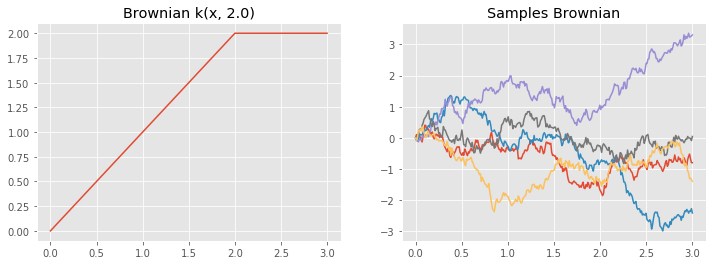

In [3]:
np.random.seed(23)  # for reproducibility

def plotkernelsample(k, ax, xmin=0, xmax=3):
    xx = np.linspace(xmin, xmax, 300)[:,None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(300), K, 5).T)
    ax.set_title('Samples ' + k.__class__.__name__)

def plotkernelfunction(k, ax, xmin=0, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    ax.plot(xx, k(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %.1f)'%other)

f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
plotkernelfunction(k_brownian, axes[0], other=2.)
plotkernelsample(k_brownian, axes[1])

## Using the kernel in a model

Because we've inherited from the `Kernel` base class, this new kernel has all the properties needed to be used in GPflow. It also has some convenience features such as allowing the user to call

`k(X, X2)`

which computes the kernel matrix.

To show that this kernel works, let's use it inside GP regression. We'll see that Brownian motion has quite interesting properties. To add a little flexibility, we'll add a `Constant` kernel to our `Brownian` kernel, and the `GPR` class will handle the noise. 

name,class,transform,trainable,shape,dtype,value
GPR.kernel.Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,2.33113
GPR.kernel.Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,0.283798
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,1.18743e-07


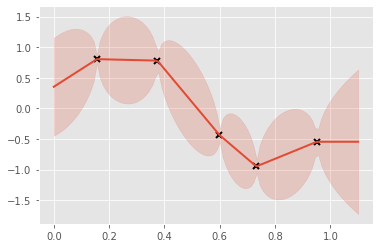

In [4]:
np.random.seed(42)
X = np.random.rand(5, 1)
Y = np.sin(X*6) + np.random.randn(*X.shape)*0.001

k1 = Brownian()
k2 = gpflow.kernels.Constant()
k = k1 + k2

m = gpflow.models.GPR((X, Y), kernel=k)
#m.likelihood.variance.assign(1e-6)

@tf.function
def objective():
    return - m.log_marginal_likelihood()
opt = gpflow.optimizers.Scipy()
opt.minimize(objective, variables=m.trainable_variables)
print_summary(m, fmt='notebook')
    
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2)
line, = plt.plot(xx, mean, lw=2)
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]),
                     color=line.get_color(), alpha=0.2)

## See also

For more details on how to manipulate existing kernels (or the one you just created!), we refer to the [Manipulating kernels](../advanced/kernels.ipynb) notebook. 